#PUBG Finish Placement Prediction

####Can you predict the battle royale finish of PUBG Players? 

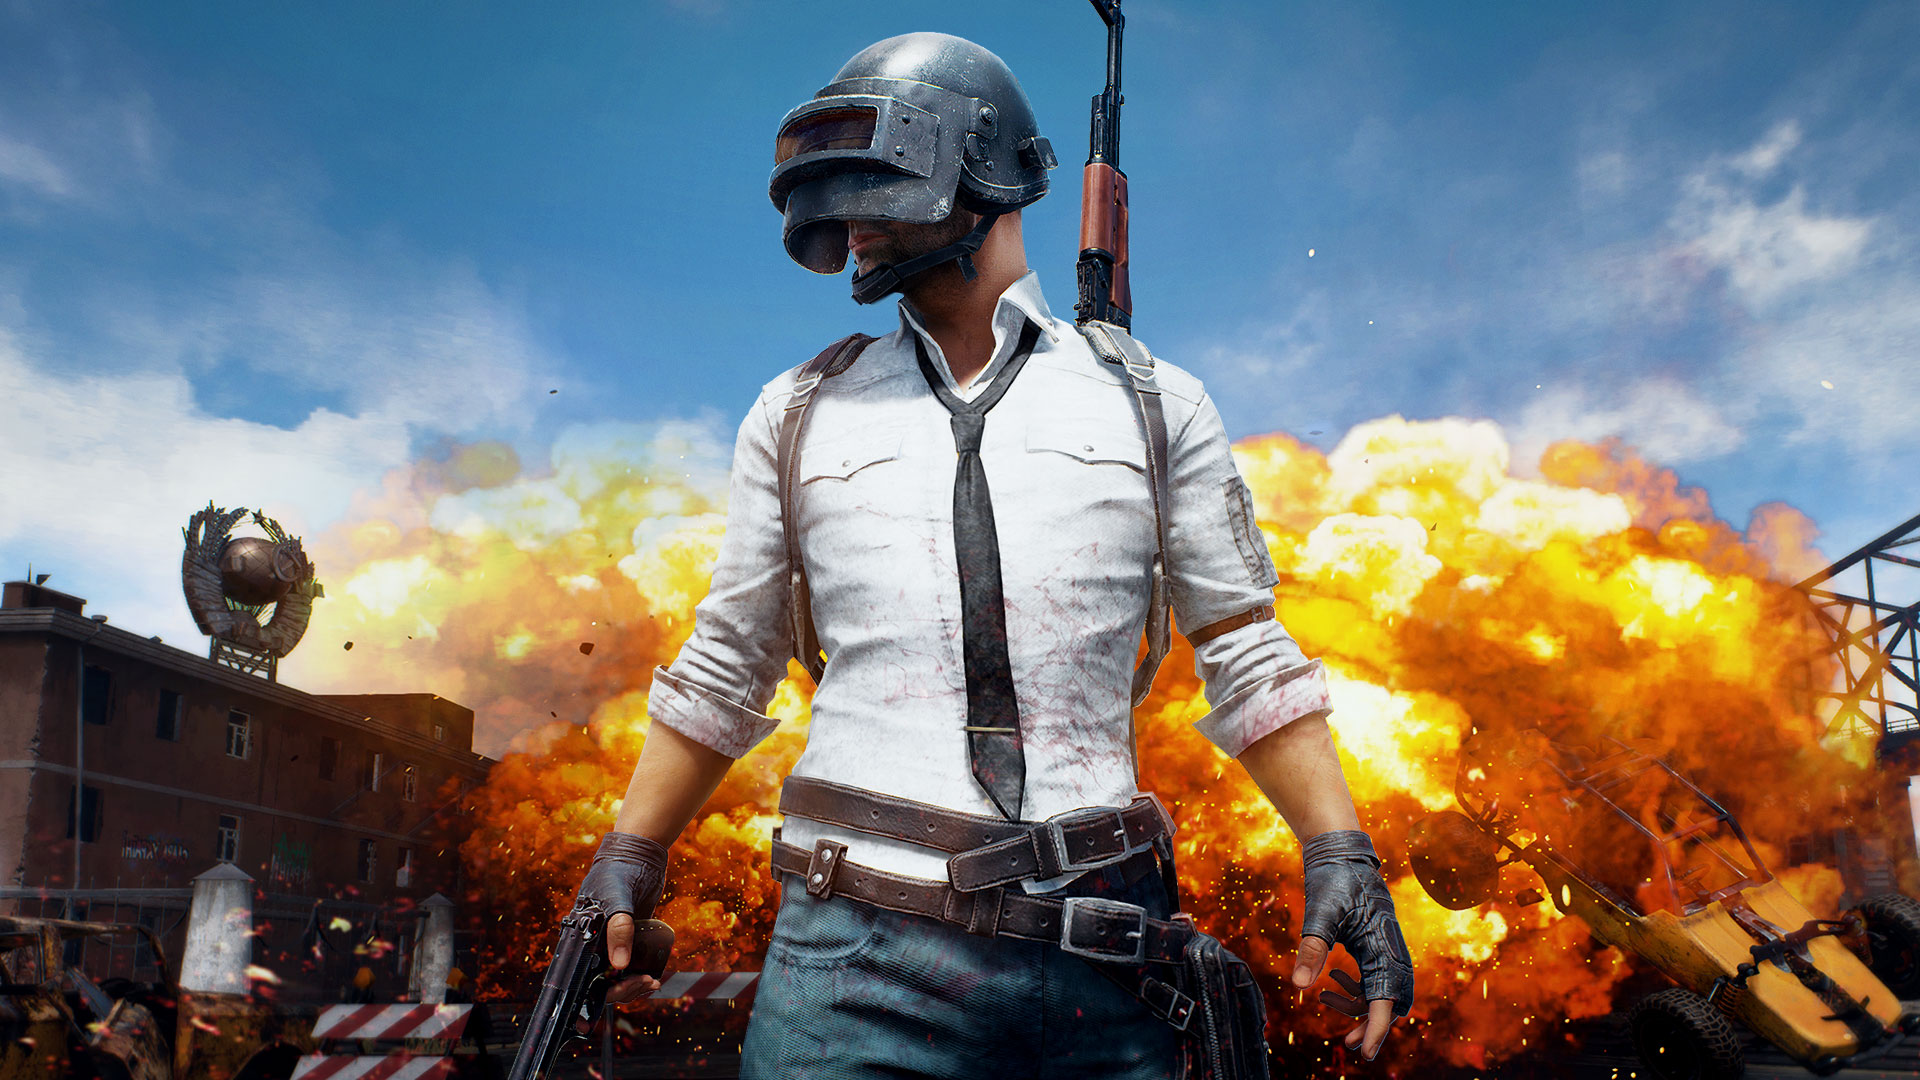

##Problem Statement

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

####Data Fields



*   **DBNOs** - Number of enemy players knocked. 
*   **assists** - Number of enemy players this player damaged that were killed by teammates.
* **boosts** - Number of boost items used.
* **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
* **headshotKills** - Number of enemy players killed with headshots.
* **heals** - Number of healing items used.
* **Id** - Player’s Id
* **killPlace** - Ranking in match of number of enemy players killed.
* **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* **killStreaks** - Max number of enemy players killed in a short amount of time.
* **kills** - Number of enemy players killed.
* **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* **matchDuration** - Duration of match in seconds.
* **matchId** - ID to identify match. There are no matches that are in both the training and testing set.
* **matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* **rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* **revives** - Number of times this player revived teammates.
* **rideDistance** - Total distance traveled in vehicles measured in meters.
* **roadKills** - Number of kills while in a vehicle.
* **swimDistance** - Total distance traveled by swimming measured in meters.
* **teamKills** - Number of times this player killed a teammate.
* **vehicleDestroys** - Number of vehicles destroyed.
* **walkDistance** - Total distance traveled on foot measured in meters.
* **weaponsAcquired** - Number of weapons picked up.
* **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* **groupId** - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* **numGroups** - Number of groups we have data for in the match.
* **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.



##Exploratory analysis and Feature Engineering

###Setting up the envornment and downloading the data

In [ ]:
!pip install pandas matplotlib seaborn plotly --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 47.8 MB/s eta 0:00:00


In [ ]:
#pip install --force-reinstall numpy==1.23.5

In [ ]:
!pip install opendatasets scikit-learn --quiet

In [ ]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os

In [ ]:
od.download('https://www.kaggle.com/competitions/pubg-finish-placement-prediction')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [ ]:
raw_df = pd.read_csv('./pubg-finish-placement-prediction/train_V2.csv')
test_df = pd.read_csv('./pubg-finish-placement-prediction/test_V2.csv')
submission_df = pd.read_csv('./pubg-finish-placement-prediction/sample_submission_V2.csv')

In [ ]:
raw_df

###Exploring the data

In [ ]:
raw_df.info()

In [ ]:
raw_df.isna().sum()

Before continuing - the one NaN value under winPlacePerc can be dropped. As this will be our target column the values being valid here are important.

In [ ]:
raw_df[raw_df['winPlacePerc'].isnull()]

In [ ]:
raw_df.drop(2744604, inplace=True)

In [ ]:
raw_df.isna().sum()

Now that the null values are removed, we can investigate how some of the values correlate with each other

While not directly related to our target variable, let's see how the columns rideDistance and roadKills relate. We would assume that there would be a direct correlation between how far someone travelled in a vehicle and how many people they killed while in a vehicle

In [ ]:
sns.set_theme(style='whitegrid')
sns.scatterplot(data=raw_df, x='roadKills', y='rideDistance')

So it turns out that more road kills does not necissarly mean further distance travelled in a vehicle. Lets see if the same stands true for distance walked and general kills

In [ ]:
sns.scatterplot(data=raw_df, x='kills', y='walkDistance')

The correlation here is similar to the vehicle distance/kills. More kills does not necissarily mean more distance travelled, in fact it seems more common that a shorter distance would lead to more kills

Now lets investigate which values directly correlate with our target column of winPlacePerc. Lets begin with a heatmap to see where the strongest correlations lie

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(raw_df.corr(), annot=True, fmt= '.1f',ax=ax)
plt.show()

From this we can see that the strongest correlations with winPlacePerc should be walkDistance, WeaponsAcquired and boosts while killPlace has the strongest negative correlation. Lets graph each of those values to see a visual representation

In [ ]:
sns.jointplot(data=raw_df, x="winPlacePerc", y="walkDistance", height=10, color='r')

In [ ]:
sns.jointplot(data=raw_df, x="winPlacePerc", y="weaponsAcquired", height=10, color='g')

In [ ]:
sns.jointplot(data=raw_df, x="winPlacePerc", y="boosts", height=10, color='b')

In [ ]:
sns.jointplot(data=raw_df, x="winPlacePerc", y="killPlace", height=10, color='purple')

### Feature Engineering 

There are a few features we could combine that may give us a better correlation and better model

The following correlation tests are taken from user Choco's PUBG Data Description A to Z + FE with Python notebook on Kaggle which can be found [here](https://www.kaggle.com/code/chocozzz/pubg-data-description-a-to-z-fe-with-python/notebook#Notebook-Outline)

####Total Distance

Let's begin by combining all the travel metrics together to see if total_distance is a good metric to include

In [ ]:
distance = raw_df[['winPlacePerc', 'walkDistance', 'swimDistance', 'rideDistance']]
distance['total_distance'] = (distance['walkDistance'] + distance['swimDistance'] + distance['rideDistance'])

In [ ]:
distance.corr()

While walkDistance is still the strongest correlation, total_distance gives us another strong value to use in our model so we will add it to the dataframe

In [ ]:
raw_df['total_distance'] = (raw_df['walkDistance'] + raw_df['swimDistance'] + raw_df['rideDistance'])
test_df['total_distance'] = (test_df['walkDistance'] + test_df['swimDistance'] + test_df['rideDistance'])

####Kills and Assists

Assists in this data set is described as "Number of enemy players this player damaged that were killed by teammates."
So assists would directly help with wins since they are specifically tied to teammate kills. Combining kills and assists would give a better picture of kills done by the team as a whole

In [ ]:
kills_assists = raw_df[['winPlacePerc', 'kills', 'assists']]
kills_assists ['kills_assists'] = (kills_assists['kills'] + kills_assists['assists']) 

In [ ]:
kills_assists.corr()

The Kills + Assists metric has a stronger correlation than kills on their own, so it can be used

In [ ]:
raw_df['kills_assists'] = (raw_df['kills'] + raw_df['assists']) 
test_df['kills_assists'] = (test_df['kills'] + test_df['assists'])

####Headshot rate

Finally we will look at adding a headshot rate metric. Headshots are the most efficient method to get a kill and having a high percentage of kills be headshots would imply the player is higher skilled.

In [ ]:
headshot = raw_df[['winPlacePerc', 'kills', 'headshotKills']]
headshot ['headshotRate'] = (headshot['kills'] / headshot['headshotKills'])

In [ ]:
headshot.corr()

While not the strongest correaltion, it is stronger than headshotKills on it's own so we will keep it

In [ ]:
raw_df['headshotRate'] = (raw_df['kills'] / raw_df['headshotKills'])
test_df['headshotRate'] = (test_df['kills'] / test_df['headshotKills'])

We will run into an issue where players with headshotKills = 0 will wind up with an infinite headshotRate. To circumvent this, we should set headshotRate to 0 for anyone who has 0 headshot kills

In [ ]:
raw_df.replace([np.inf, -np.inf], 0, inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
raw_df['headshotRate'] = raw_df['headshotRate'].fillna(0)
test_df['headshotRate'] = test_df['headshotRate'].fillna(0)

##Preparing the Data for Training

Now that we've created some new features and have had a quick look at the data, we can start preparing our sets for training

###Identify input and target columns

In [ ]:
raw_df.columns

Id, groupId and matchId are unlikely to have any impact on winPlacePerc so we can ignore those when it comes to inputs

In [ ]:
input_cols = ['assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'total_distance',
       'kills_assists', 'headshotRate']
target_col = ['winPlacePerc']

In [ ]:
inputs_df = raw_df[input_cols].copy()
targets = raw_df[target_col].copy()
test_inputs_df = test_df[input_cols].copy()

###Identify numeric and categorical columns

The only categorical column we should have remaining is the match type column

In [ ]:
raw_df[input_cols].select_dtypes(include=np.number).columns.tolist()


In [ ]:
numeric_cols = raw_df[input_cols].select_dtypes(include=np.number).columns.tolist()

In [ ]:
raw_df[input_cols].select_dtypes(include='object').columns.tolist()

In [ ]:
categorical_cols = raw_df[input_cols].select_dtypes(include='object').columns.tolist()

###Scale the numeric columns

In [ ]:
inputs_df[numeric_cols].isna().sum()

In [ ]:
test_inputs_df[numeric_cols].isna().sum()

Since there are no missing numeric values, we do not need to impute any data. We will scale values to make them easier to compare

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

In [ ]:
scaler = MinMaxScaler().fit(test_inputs_df[numeric_cols])
test_inputs_df[numeric_cols] = scaler.transform(test_inputs_df[numeric_cols])

###Encoding categorical columns 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
test_inputs_df[encoded_cols] = encoder.transform(test_inputs_df[categorical_cols])

In [ ]:
inputs_df.info()

In [ ]:
test_inputs_df.info()

###Memory Reduction

Thanks and credited to https://www.kaggle.com/gemartin who created this wonderful mem reducer

In [ ]:

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

inputs_df = reduce_mem_usage(inputs_df)
test_inputs_df = reduce_mem_usage(test_inputs_df)

In [ ]:
inputs_df.info()

In [ ]:
test_inputs_df.info()

###Creating training and validation splits

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

In [ ]:
train_inputs.info()

In [ ]:
val_inputs.info()

In [ ]:
test_inputs = test_inputs_df[numeric_cols + encoded_cols]

In [ ]:
test_inputs.info()

##Decision Tree

The first model we will train is a Decision Tree, and use the jovian random forests assignment as a reference [found here](https://jovian.com/develled/python-random-forests-assignment)

We are opting for a regression tree as oposed to a classification tree. While a classification tree may seem like the correct choice at first - since we are trying to determine if someone will win or not - the result will not turn out as 'yes' and 'no' but instead as the winPlacePerc, which is represented by a percentage

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(train_inputs, train_targets)

Before we do any hyperperameter tuning we do not expect that the RMSE will be great for the validation set, but let's see where our starting point is

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
tree_train_preds = tree.predict(train_inputs)
tree_train_rmse = mean_squared_error(tree_train_preds, train_targets, squared=False)
tree_val_preds = tree.predict(val_inputs)
tree_val_rmse = mean_squared_error(tree_val_preds, val_targets, squared=False)

In [ ]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

As expected our model has been overfit with the training data.

####Feature Importance

Let's look into the most important features and see if they line up with what our exploratory analysis showed

In [ ]:
tree_importances = tree.feature_importances_

In [ ]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [ ]:
tree_importance_df.head(10)

In [ ]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

Unsuprisingly the walkDistance is still the most important feature, which is what we saw from our intial heatmap. And killPlace had the second strongest correlation albeit a negative one. However boosts and weaponsAcquired both fall outside of the top 10

###Hyperparameter Tuning

####Max Depth

In [ ]:
tree.get_depth()

The Max Depth is the first thing we will tune on our tree as it typically has the strongest link to overfitting. To determine the best value for the Max Depth, we will use a helper function that can be found in Jovian's [Decision Trees and Random Forests lesson](https://jovian.com/develled/sklearn-decision-trees-random-forests#C104)

This function will iterate over different values of the max depth and graph the results for us so we can pinpoint the best value.
The main difference between our function and the one on Jovian is we will use plotly to graph the results so we can interact with the graph

In [ ]:
## This function creates a new decision tree and returns 1 - the model score for both the training set and validation set

def max_depth_error(md):
    model = DecisionTreeRegressor(max_depth=md, random_state=42)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
## We will then iterate over a range of Max Depths. We know 68 is too high, so to lighten the load on our system we will iterate from 1 to 25 Max Depth to begin
%%time
max_depth_test = pd.DataFrame([max_depth_error(md) for md in range (1, 26)])

In [ ]:
max_depth_test

In [ ]:
import plotly.express as px

In [ ]:
fig = px.line()
fig.add_scatter(x=max_depth_test['Max Depth'], y=max_depth_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=max_depth_test['Max Depth'], y=max_depth_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='Max Depth', yaxis_title='Error')
fig.show()

This shows us that the best value for Max Depth is 16. We will use that going forward when we tune other parameters

In [ ]:
tree = DecisionTreeRegressor(max_depth = 16, random_state=42)
tree.fit(train_inputs, train_targets)

In [ ]:
tree_train_preds = tree.predict(train_inputs)
tree_train_rmse = mean_squared_error(tree_train_preds, train_targets, squared=False)
tree_val_preds = tree.predict(val_inputs)
tree_val_rmse = mean_squared_error(tree_val_preds, val_targets, squared=False)

In [ ]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

The validation error has improved from 0.1164 to 0.0877 which is a big improvment from one hyperparameter and our model is quicker thanks to a shorter depth.

####Max Leaf Nodes

The next hyperparameter we will tune is max leaf nodes, we can use a similar function as the max depth to achieve this

In [ ]:
def max_leaf_nodes_error(n):
    model = DecisionTreeRegressor(max_depth=16, max_leaf_nodes=n, random_state=42)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'Max Leaf Nodes': n, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
%%time
max_leaf_nodes_test = pd.DataFrame([max_leaf_nodes_error(n) for n in range (1000, 15001, 1000)])

In [ ]:
max_leaf_nodes_test

In [ ]:
fig = px.line()
fig.add_scatter(x=max_leaf_nodes_test['Max Leaf Nodes'], y=max_leaf_nodes_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=max_leaf_nodes_test['Max Leaf Nodes'], y=max_leaf_nodes_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='Max Leaf Nodes', yaxis_title='Error')
fig.show()

It looks like a Max Leaf Nodes value of 10000 gives us the best error. We could lock it in even further by iterating over every 100 between 9000 and 11000, but given how close the error is between 9000 and 11000 already the difference would likely be negligible.

In [ ]:
tree = DecisionTreeRegressor(max_depth = 16, max_leaf_nodes = 10000, random_state=42)
tree.fit(train_inputs, train_targets)

In [ ]:
tree_train_preds = tree.predict(train_inputs)
tree_train_rmse = mean_squared_error(tree_train_preds, train_targets, squared=False)
tree_val_preds = tree.predict(val_inputs)
tree_val_rmse = mean_squared_error(tree_val_preds, val_targets, squared=False)

In [ ]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Our RMSE has improved from 0.0877 to 0.0871. A much smaller jump than the inital one after tuning our first hyperparameter. 

###Decision Tree Predictions

We could tune more hyperparameters to make an even more accurate model, but the improvements are likely to be incremental and we will work on training a different model instead. So for now we will make our final predictions on the test set

In [ ]:
test_inputs

In [ ]:
final_tree = DecisionTreeRegressor(max_depth = 16, max_leaf_nodes = 10000, random_state=42)
final_tree.fit(train_inputs, train_targets)

In [ ]:
test_preds = final_tree.predict(test_inputs)

In [ ]:
submission_df

In [ ]:
submission_df['winPlacePerc'] = test_preds

In [ ]:
submission_df.to_csv('submission.csv', index=False)

The Decision Tree resulted in a 0.06983 score in the Kaggle competition which would be around 1170/1528 on the leaderboard. Not a great result, our next model should show some improvement on that number

##Gradient Boosting

The next model we will train is a GBM using Jovian's [Gradient Boosting Machines (GBMs) with XGBoost](https://jovian.com/develled/python-gradient-boosting-machines#C91) as a reference

We are going to use lightGBM instead of XGboost to save on run time. The accuracy may be a little lower, but with how fast the model can run we can tune more parameters 

In [ ]:
import lightgbm as ltb

In [ ]:
GBM = ltb.LGBMRegressor(random_state=26, n_jobs=-1)

In [ ]:
%%time
GBM.fit(train_inputs, train_targets)

In [ ]:
GBM_train_preds = GBM.predict(train_inputs)
GBM_train_rmse = mean_squared_error(GBM_train_preds, train_targets, squared=False)
GBM_val_preds = GBM.predict(val_inputs)
GBM_val_rmse = mean_squared_error(GBM_val_preds, val_targets, squared=False)

In [ ]:
'Train RMSE: {}, Validation RMSE: {}'.format(GBM_train_rmse, GBM_val_rmse)

Already without any tuning, our GBM has a better validation RMSE than our best Decision tree did (0.0871)

###Feature Importance

Let's see how the feature importance of our GBM lines up with the importances we saw with decision tree

In [ ]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': GBM.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

The most noteable differences are that walkDistance is no longer overwhelmingly important to the model and numGroups went from a weak 4th place to a strong 2nd

###Hyperparameter Tuning

We are going to be searching for the best values of n_estimators, max depth, num leaves, learning rate and min child weight. We will then combine all our best parameters at the end to see how much we have improved.

####n_estimators

The default value for n_estimators in a LightGBM Regressor is 100, so we will use that as our baseline

In [ ]:
def GBM_estimators(ne):
    model = ltb.LGBMRegressor(n_estimators=ne, random_state=26, n_jobs=-1)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'n_estimators': ne, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
GBM_estimator_test = pd.DataFrame([GBM_estimators(ne) for ne in range (200,1700,200)])

In [ ]:
GBM_estimator_test

In [ ]:


fig = px.line()
fig.add_scatter(x=GBM_estimator_test['n_estimators'], y=GBM_estimator_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=GBM_estimator_test['n_estimators'], y=GBM_estimator_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='n_estimators', yaxis_title='Error')
fig.show()

The validation error keeps improving but the improvements get pretty small from 1500 onwards - in order to have a model that can run efficiently while being accurate, we will use n_estimators = 1400

####Max Depth

In [ ]:
def GBM_depth(md):
    model = ltb.LGBMRegressor(max_depth=md, random_state=26, n_jobs=-1)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'max_depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
GBM_depth_test = pd.DataFrame([GBM_depth(md) for md in range (3, 21, 2)])

In [ ]:
GBM_depth_test

In [ ]:
fig = px.line()
fig.add_scatter(x=GBM_depth_test['max_depth'], y=GBM_depth_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=GBM_depth_test['max_depth'], y=GBM_depth_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='max_depth', yaxis_title='Error')
fig.show()

The best validation error we get is with a Max Depth of 17, so we will use that for our test going forward.

From here on we will carry through our best parameters. We are excluding n_estimators from this just because it adds the most to the runtime.

####Number of Leaves

The default value of num_leaves in our model is 31, so we will test models below and above that to find the best value

In [ ]:
def GBM_leaves(n):
    model = ltb.LGBMRegressor(num_leaves = n, max_depth = 17, random_state=26, n_jobs=-1)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'num_leaves': n, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
GBM_leaves_test = pd.DataFrame([GBM_leaves(n) for n in range (100, 501, 20)])

In [ ]:
GBM_leaves_test

In [ ]:
fig = px.line()
fig.add_scatter(x=GBM_leaves_test['num_leaves'], y=GBM_leaves_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=GBM_leaves_test['num_leaves'], y=GBM_leaves_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='num_leaves', yaxis_title='Error')
fig.show()

The error is continuously improving as we increase the number of leaves, but it seems to taper off around 400 and the improvements get more and more incremental.

While it may not be the best value we can get, we are going to move forward with 400 for number of leaves. It seems like a good balance between good error and shorter run time.

####Min Child Samples

In [ ]:
def GBM_child_samples(cs):
    model = ltb.LGBMRegressor(min_child_samples = cs, num_leaves = 400, max_depth = 17, random_state=26, n_jobs=-1)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'min_child_samples': cs, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
GBM_child_samples_test = pd.DataFrame([GBM_child_samples(cs) for cs in range (10, 150, 10)])

In [ ]:
GBM_child_samples_test

In [ ]:
fig = px.line()
fig.add_scatter(x=GBM_child_samples_test['min_child_samples'], y=GBM_child_samples_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=GBM_child_samples_test['min_child_samples'], y=GBM_child_samples_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='min_child_samples', yaxis_title='Error')
fig.show()

The best value for child samples from our test appear to be around 20 which is the default value of LightGBM, so we will use that going forward in our model

####Min Split Gain

In [ ]:
def GBM_split_gain(sg):
    model = ltb.LGBMRegressor(min_split_gain = sg, min_child_samples = 20, num_leaves = 400, max_depth = 17, random_state=26, n_jobs=-1)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'min_split_gain': sg, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
%%time
GBM_split_gain_test = pd.DataFrame([GBM_split_gain(sg) for sg in range (0, 15)])

In [ ]:
GBM_split_gain_test

In [ ]:
fig = px.line()
fig.add_scatter(x=GBM_split_gain_test['min_split_gain'], y=GBM_split_gain_test['Training Error'], name = 'Training Error')
fig.add_scatter(x=GBM_split_gain_test['min_split_gain'], y=GBM_split_gain_test['Validation Error'], name = 'Validation Error')
fig.update_layout(title='Training and Validation error', xaxis_title='min_split_gain', yaxis_title='Error')
fig.show()

The best min split gain is 0 which is the default value, so we are not gaining anything by adjusting it.

###Final Model and Predictions

After tuning several hyperparameters, the best model we can build is one with n_estimators of 1400, a Max Depth of 17, 400 leaves, 20 min child samples and min split gain of 0. Lets see how our fully tuned model fares below in comparison to the untuned model with a 0.083168 validation RMSE

In [ ]:
finalGBM = ltb.LGBMRegressor(n_estimators = 1400, max_depth = 17, num_leaves = 400, min_child_samples = 20, min_split_gain = 0, random_state=26, n_jobs=-1)

In [ ]:
%%time
finalGBM.fit(train_inputs, train_targets)

In [ ]:
finalGBM_train_preds = finalGBM.predict(train_inputs)
finalGBM_train_rmse = mean_squared_error(finalGBM_train_preds, train_targets, squared=False)
finalGBM_val_preds = finalGBM.predict(val_inputs)
finalGBM_val_rmse = mean_squared_error(finalGBM_val_preds, val_targets, squared=False)

In [ ]:
'Train RMSE: {}, Validation RMSE: {}'.format(finalGBM_train_rmse, finalGBM_val_rmse)

We got our validation RMSE down to 0.076266 which is a great improvment from the initial 0.083168 and a huge improvment from our decision tree which was 0.0871 afdter tuning.

In [ ]:
GBM_test_preds = finalGBM.predict(test_inputs)

In [ ]:
submission_df['winPlacePerc'] = GBM_test_preds

In [ ]:
submission_df

In [ ]:
submission_df.to_csv('submission.csv', index=False)

The new model got a score of 0.06701 on the kaggle competition, which is a small improvement over just the Decision Tree.

##Summary

Our GBM model is noticably better than the single Decision Tree which isn't too shocking. The model itself lends itself to being more accurate at the outset given it includes multiple decision trees that account for the error of others. And we tuned more paramters as well. There are some tweeks we can do to our process and the final model that we can go over below.

###Future Work to Improve the model

####Outlier Detection

To make our training data more accurate, we could identify and remove a handful of outliers. Players who got kills without moving or players who had a perfect headshot rate would likely be able to removed from the data sets as they would be cheaters. Removing these outliers would make our predictive analysis more accurate.

We could also look at removing outliers to other columns like kills and longest kill. Players who got over 50 kills for example would either be cheaters or just a very unlikly scenario to replicate. Having those numbers in there could skew some of our predictions.

####More Feature Engineering

Along with removing outliers, there are some more features we could add to our model in the feature engineering section. Finding the Kill Streak rate, total health items, ratio of kill place to max place and kills per walk distance all seem to have improved other models and could be implemented in ours as well to make some improvements.

Additionally we could streamline the 'Match Type' column to simply include the 3 main match types of Solo, Duos and Squads.

####More Hyperparmeter Tuning

We tuned several hyperparameters and iterated over large sections to narrow in on the best model. However there are some additional hyperparamaters that could be included to improve the model further, and we could try tuning with different strategies as well.

We didn't find the optimal hyperparamter for each value either - we had to make some sacrifices so our model would be able to run and test in a reasonable amount of time. But to improve the model, we would need to test mroe paramteters and larger parameters, sacrificing run time for accuracy.

Instead of tuning each hyperparameter individually and carrying that value forward, we could have used a method like Grid Search to tune all parameters at once. Since certain values would have an effect on each other, this would ensure that we get the best values for each when their effects on the other parameters are taken into account.